# Fitting a Straight Line to (Fake) Data

**AY128/256 UC Berkeley**

## A simple, practical example of
* Bayesian Inference 
* Markov chain Monte Carlo (MCMC)

For this example, you'll need to have `emcee` and `corner` installed.

```bash
pip install corner emcee
```

In [86]:
%run ../talktools.py

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Make a Fake Dataset

* N data points 
* Linear model : $y = mx + b$

In [70]:
Ndata = 10 # number of data points
m_true = 3 # true slope
b_true = -2 # true intercept

## Add Gaussian Noise to the fake data

* Compute our model: $y = mx + b$
* Compute error bars, by randomly drawing them from a uniform distribution [0.1,0.7]
* Assume that each data point $y$ is the mean of a normal distribution and that error bar is the standard deviation
* Then we can resample the model to make it look noisy

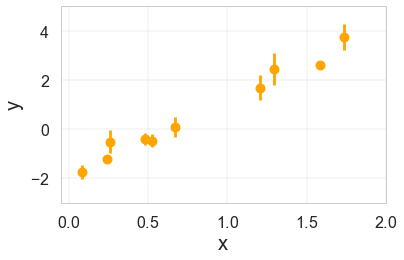

In [71]:
# set the random seed
seed =   128  
rnd = np.random.RandomState(seed)

# create a set of x points with length N data from a uniform distritubion
xmin, xmax = 0, 2
x = rnd.uniform(xmin, xmax, Ndata)
x.sort()  # sort them in place

# create noiseless fake y data using x and true slope and intercept
y_data = m_true * x + b_true

# create y error bars from a uniform distribution
y_err_min, y_err_max = 0.1, 0.7
y_err = rnd.uniform(y_err_min, y_err_max, Ndata)

# add Gaussian noise to fake y data by re-sampling
# assume each noiseless y data point (from above) and y_err are the mean
# and standard deviation of a normal distribution
# use this to make noisy data
y_data = rnd.normal(y_data, y_err)

# plot the data
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', ms=10, c='orange')
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xlim(-0.05, 2)
plt.ylim(-3, 5)
plt.tight_layout()

## Pretend we don't the know how the fake data were generated...

* Looks like a linear model is reasonable: $y = mx + b$
* Two parameters: $m$, $b$
* Assume errors are normally distributed
* Assume data are drawn independently and identically (IID)

### Write down model-data relationship using Bayesian notation

## In linear space:

## $P(m,b \mid D) \propto\ P(D \mid m,b) \ P(m,b)$

## In log space:

## $\log{P(m,b \mid D)} \propto\ \log{P(D \mid m,b)} + \log{P(m,b)}$
* Note that log = natural log (not base 10)

### Let's define the likelihood function for single data point
* Likelihood function (assuming IID and normally distributed data/errors):
   ## $P(D_i \mid m,b) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} e^{-\frac{(D_i - y_i)^2}{2\sigma_i^2}}$
* log-Likelihood function:
   ##  $\log{P(D_i \mid m,b)} \propto\ -0.5 \big( {{\frac{(D_i - y_i)^2}{\sigma_i^2}}} - \log{(\frac{1}{\sigma_i^2})} \big)$
   
   * Some constants got dropped (e.g., $\pi$)

### Now, assuming IID, let's write down the likelihood function for the entire dataset:
* ### Linear space: IID $\rightarrow P(D \mid m,b) = \prod\limits_{i} P(D_i \mid m,b)$
* ### log space: IID $\rightarrow \log{P(D \mid m,b)} = \sum\limits_{i} \log{P(D_i \mid m,b)}$
* ### log space: $\log{P(D \mid m,b)} = -0.5 \ \sum\limits_{i}   \big({{\frac{(D_i - y_i)^2}{\sigma_i^2}}} - \log{(\frac{1}{\sigma_i^2})} \big)$

### The log-likelihood function in python:

In [72]:
# function for log-likelihood
# assumes theta = {m,b}
# takes theta and data: (x,y,yerr)
# returns log-likelihood value for entire dataset 
# given one value of m and one value of b
def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

### Decide on some priors:

* Using simple top-hat priors
 - Simple to implement, but they qualitfy as "uninformative"
 

*   $P(m,b) = \left\{\begin{array}{lr}
        1, & \text{for } -5\leq m\leq 5 \ \text{and} -5\leq b\leq 5 \\
        0, & \text{otherwise }
        \end{array}\right\}$
        
 
*   $\log{P(m,b)} = \left\{\begin{array}{lr}
        0, & \text{for } -5\leq m\leq 5 \ \text{and} -5\leq b\leq 5 \\
        -\infty, & \text{otherwise }
        \end{array}\right\}$

### The log-prior in python:

In [73]:
# function that takes in theta - (m,b) and 
# returns log-prior if priors are within bounds 
# return -inf if priors are outside of the bounds
# if you're sampler can't handle -inf, you can use a very small number
# (e.g., -1e6) as a kludge
def lnprior(theta):
    m, b = theta
    if -5.0 <= m <= 5.0 and -5 <= b <= 5:
        return 0.0
    return -np.inf

## Posterior:

The log-posterior is the sum of the log-likelihood and log-prior: 
## $\log{P(m,b \mid D)} = \log{P(D \mid m,b)} + \log{P(m,b)}$.

### The log-posterior function in python:

In [74]:
# takes in theta=(m,b) and data = (x,y, yerr)
# returns a log probability if finite
# retrns -inf if not finite
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

### Sample the posterior using emcee:

* need to define: 
    - number of "walkers", number of dimensions (free parameters, variables, etc)
* give walkers initial guess

In [75]:
#seed =   128  
#rnd = np.random.RandomState(seed)

ndim, nwalkers = 2, 16
initial_m, initial_b = m_true, b_true-1
pos = [(initial_m, initial_b) + 1e-4*rnd.randn(ndim) for i in range(nwalkers)]

### Let's look at the starting positions:

In [76]:
print(np.asarray(pos).shape)
print(pos)

(16, 2)
[array([ 3.00003742, -3.00008788]), array([ 3.00002703, -3.00000427]), array([ 2.99985099, -3.00005869]), array([ 3.00005233, -3.00004315]), array([ 2.99990076, -2.99993626]), array([ 3.00008199, -2.99994977]), array([ 3.00008512, -2.9999162 ]), array([ 2.99992738, -3.00007731]), array([ 2.99987236, -2.99995175]), array([ 2.99996937, -3.00014027]), array([ 3.00015444, -2.99995896]), array([ 3.00019715, -2.99998136]), array([ 3.00001134, -3.00000641]), array([ 2.99995069, -2.99994693]), array([ 3.00001676, -2.99985202]), array([ 3.00001927, -3.00006197])]


#### $\texttt{pos}$ is a set of 16 pairs of initial guesses for m and b for each walker.

### Import emcee and set up to run according to documentation:

In [77]:
import emcee
print(f"emcee version = {emcee.__version__}")
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_data, y_err))

emcee version = 2.2.1


### Decide on number of MCMC steps, start the sampler, and time it:

In [78]:
import time
start_time = time.time()

niterations = 1000
# make sure to reset the sampler so it doesn't keep appending onto old results
sampler.reset()
sampler.run_mcmc(pos, niterations)

end_time = time.time() - start_time
print(f"This run took: {np.around(end_time,2)} seconds")

This run took: 0.45 seconds


#### Some things the sampler returns:

In [79]:
print(sampler.chain.shape) # ndim, nwalker, # of parameters
print(sampler.flatchain.shape) # ndim * nwalker, # of parameters 

(16, 1000, 2)
(16000, 2)


### Some visual diagnostics of MCMC chains

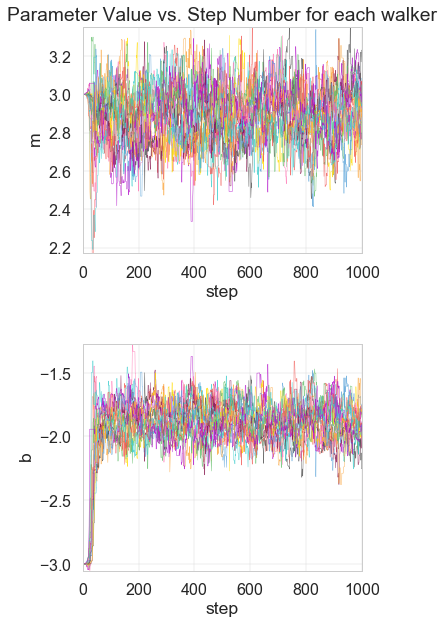

In [80]:
fig, ax = plt.subplots(2,1, figsize=(5,10))
y_labels = ['$m$', '$b$']
x_labels = 'step'
ax[0].set_title('Parameter Value vs. Step Number for each walker')
for i,j in enumerate(sampler.chain[0,0,:]):
    ax[i].plot(sampler.chain[:,:,i].T, alpha=0.8, lw=0.5)
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_xlabel(x_labels)
plt.subplots_adjust(hspace=0.4)

(-68.736589908399111, 12.749188346650126)

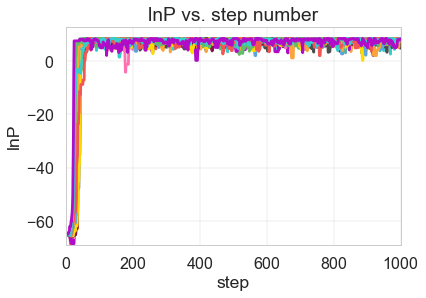

In [81]:
plt.plot(sampler.lnprobability.T)
plt.ylabel('lnP')
plt.xlabel('step')
plt.title('lnP vs. step number')
plt.ylim(sampler.lnprobability.min(), sampler.lnprobability.max()*1.5)

#### Implement "burn in" 

* Let's remove the first 200 steps from the chain

* This is a total kludge, there are better ways to do this

In [82]:
# let's remove the first 100 steps as "burn in"
# they are still sensitive to the initial conditions
burn_in = 200
samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

#### Make a "corner plot"

* ### This plots 
* the marginalized 1-d probability distributions
* the 2-d joint distribution(s)
* sometimes called "triangle" plots

corner version=2.0.1


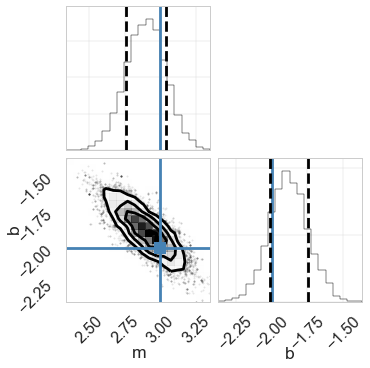

In [83]:
import corner
print(f"corner version={corner.__version__}")
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_true, b_true], quantiles=[0.16, 0.84])

#### Plot draws from the posterior along with data and truth

* Randomly draw a model from your posterior function (e.g., pick an $m$ and $b$, and compute $y=mx+b$)

* plot the line in lack with low transparency

* repeat 100 times (in this case)

* regions of higher density illustrate regions of higher probability

* Also known as a "posterior predictive check"


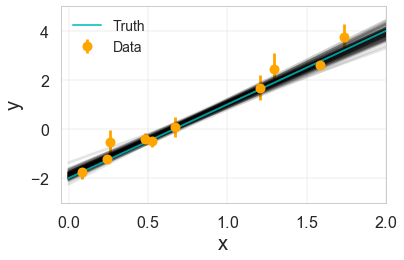

In [87]:
# create an array of x values
xl = np.array([0, 2])

# randomly draw 100 points from my posterior (i.e., the MCMC chain)
# and plot them as thin black lines
for m, b in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)

# plot the true model from the very beginning
plt.plot(xl, m_true*xl+b_true, color="c", lw=2, alpha=0.8, label='Truth')

# plot the fake data with error bars
plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', ms=10, c='orange', label='Data')

#set some limits on the plot
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xlim(-0.05, 2)
plt.ylim(-3,5)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()

### Finally, let's compute some summary statistics

* For example, you may want to present numbers in an abstract, or list them in a table
* A growing trend is to publish your likelihood function and/or MCMC chains
* What point statistics to publish (e.g., maximum likelihood, maximum a posteriori, ...)?
* Here, I've selected to compute the median, and the 16th and 84th percentiles of the 1-d PDFs, 
 - This interval spans the 68% range around the median (i.e., a semi-equivalent to 1-$\sigma$ for a normal distribution)

In [85]:
#compute summary statistics: 50, 16, 84 percentiles

m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(f"true m value: {m_true}")
print(f"mcmc median, +/- for m: {m_mcmc}\n")

print(f"true b value: {b_true}")
print(f"mcmc median, +/- for b: {b_mcmc}")
# note to self: figure out correct way to format f-strings + latex

true m value: 3
mcmc median, +/- for m: (2.8976306783267201, 0.13828859359205525, 0.14306802762993298)

true b value: -2
mcmc median, +/- for b: (-1.8831090746868644, 0.13536241714547348, 0.13073083993987478)


### What should we make of this point estimate?

* Is it a problem that the median values aren't the same as the true values?

### Generally at this stage, there are lots of questions:
* #### how do my results change with:
    - number of data points
    - size of error bars
    - number of walkers
    - number of steps
    - initial walker position guess
    - number of burn in steps
    
* #### how many walkers should I use?

* #### how do I make an initial guess for walker positions?

* #### how long should the chain run? or how do I know the chain is converged?

* #### ...
    